## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, glob
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from sklearn.utils import shuffle

## Hyperparameters

In [2]:
INPUT_DIM = 6
HIDDEN_DIM1 = 64
HIDDEN_DIM2 = 32
# OUTPUT_DIM = 10
TIMESTEPS = 50
TRAIN_RATIO = 0.8
EPOCHS = 500
LEARNING_RATE = 0.00001
MAX_GRAD_NORM = 1.0
SEED = 13
DATA_PATH = "./Dataset/"
STATEFUL = False

In [3]:
np.random.seed(SEED)

## Load Dataset

In [4]:
# file_paths = sorted(glob.glob(os.path.join(DATA_PATH, "*.csv")))
file_paths = "./Dataset/har70+_505.csv"

In [5]:
df = pd.read_csv(file_paths)
har_data = df

In [6]:
# all_data = []
# for file in file_paths:
#     df = pd.read_csv(file)
#     df['source_file'] = os.path.basename(file)
#     all_data.append(df)

# har_data = pd.concat(all_data, ignore_index=True)

## Data Visualization

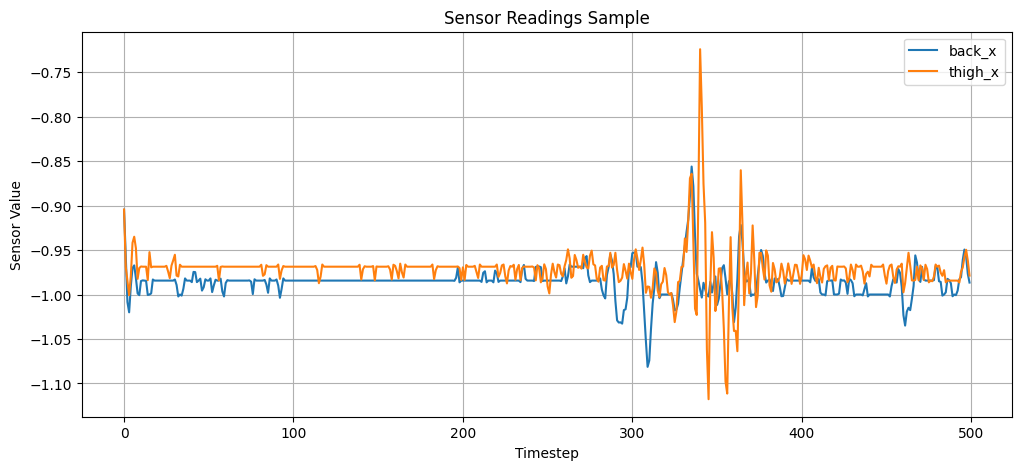

In [7]:
plt.figure(figsize=(12, 5))
plt.plot(har_data['back_x'][:500], label="back_x")
plt.plot(har_data['thigh_x'][:500], label="thigh_x")
plt.title("Sensor Readings Sample")
plt.xlabel("Timestep")
plt.ylabel("Sensor Value")
plt.legend()
plt.grid(True)
plt.show()

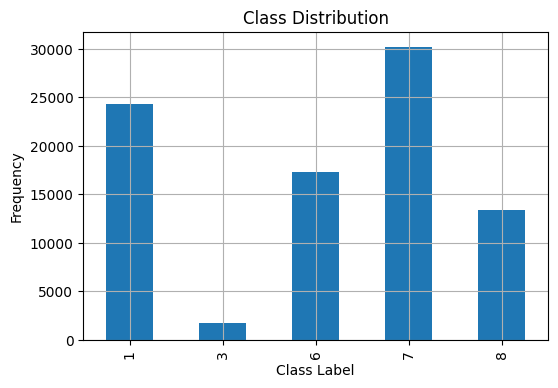

In [8]:
plt.figure(figsize=(6, 4))
har_data['label'].value_counts().sort_index().plot(kind='bar')
plt.title("Class Distribution")
plt.xlabel("Class Label")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

## Data Preprocessing

In [9]:
features = ['back_x', 'back_y', 'back_z', 'thigh_x', 'thigh_y', 'thigh_z']
X_raw = har_data[features].values
y_raw = har_data['label'].values

In [10]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_raw)

In [11]:
def create_lstm_sequences(X, y, timesteps=50):
    X_seq, y_seq = [], []
    for i in range(len(X) - timesteps):
        X_seq.append(X[i:i+timesteps])
        y_seq.append(y[i+timesteps-1])
    return np.array(X_seq), np.array(y_seq)

In [12]:
X_seq, y_seq = create_lstm_sequences(X_scaled, y_raw, TIMESTEPS)

In [13]:
unique_labels = np.unique(y_seq)
print("Original labels before mapping:", unique_labels)

label_map = {old: new for new, old in enumerate(unique_labels)}
print("\nLabel mapping:")
for original, new in label_map.items():
    print(f"  Original Label {original} → Mapped Label {new}")

print("\nClass Distribution before Mapping:")
unique, counts = np.unique(y_seq, return_counts=True)
for cls, count in zip(unique, counts):
    print(f"  Class {cls}: {count} samples")

print("\ny_seq range:", y_seq.min(), "to", y_seq.max())

Original labels before mapping: [1 3 6 7 8]

Label mapping:
  Original Label 1 → Mapped Label 0
  Original Label 3 → Mapped Label 1
  Original Label 6 → Mapped Label 2
  Original Label 7 → Mapped Label 3
  Original Label 8 → Mapped Label 4

Class Distribution before Mapping:
  Class 1: 24313 samples
  Class 3: 1768 samples
  Class 6: 17269 samples
  Class 7: 30226 samples
  Class 8: 13380 samples

y_seq range: 1 to 8


In [14]:
# unique_labels = np.unique(y_seq)
# print(unique_labels)
# label_map = {old: new for new, old in enumerate(unique_labels)}

In [15]:
y_seq_mapped = np.array([label_map[y] for y in y_seq])

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq_mapped, test_size=1-TRAIN_RATIO, random_state=SEED, stratify=y_seq_mapped)

In [17]:
np.unique(y_train), y_train.min(), y_train.max()

(array([0, 1, 2, 3, 4]), 0, 4)

In [18]:
OUTPUT_DIM = len(unique_labels)

In [19]:
print(OUTPUT_DIM)

5


In [20]:
print("Class Distribution After Mapping:")
unique, counts = np.unique(y_train, return_counts=True)
for cls, count in zip(unique, counts):
    print(f"Class {cls}: {count} samples")

print("\ny_train range:", y_train.min(), "to", y_train.max())
print("OUTPUT_DIM:", OUTPUT_DIM)

Class Distribution After Mapping:
Class 0: 19450 samples
Class 1: 1414 samples
Class 2: 13815 samples
Class 3: 24181 samples
Class 4: 10704 samples

y_train range: 0 to 4
OUTPUT_DIM: 5


## Data Rebalancing

In [21]:
X_reshaped = X_seq.reshape(len(X_seq), -1)
rus = RandomUnderSampler(random_state=SEED)
X_balanced, y_balanced = rus.fit_resample(X_reshaped, y_seq_mapped)
X_balanced = X_balanced.reshape(-1, TIMESTEPS, INPUT_DIM)
X_balanced, y_balanced = shuffle(X_balanced, y_balanced, random_state=SEED)

In [22]:
X_train, X_test, y_train, y_test = train_test_split(
    X_balanced, y_balanced, test_size=1 - TRAIN_RATIO, random_state=SEED, stratify=y_balanced
)

In [23]:
_, counts = np.unique(y_train, return_counts=True)
total = np.sum(counts)
class_weights = total / (counts * len(counts))

## Create Sequence

In [24]:
def create_lstm_sequences(X, y, timesteps=50):
    X_seq, y_seq = [], []
    for i in range(len(X) - timesteps):
        X_seq.append(X[i:i+timesteps])
        y_seq.append(y[i+timesteps-1])
    return np.array(X_seq), np.array(y_seq)

## Batch Norm

In [25]:
class BatchNorm:
    def __init__(self, dim, eps=1e-5):
        self.gamma = np.ones((dim, 1))
        self.beta = np.zeros((dim, 1))
        self.eps = eps

    def forward(self, x):
        self.mu = np.mean(x, keepdims=True)
        self.var = np.var(x, keepdims=True)
        self.x_norm = (x - self.mu) / np.sqrt(self.var + self.eps)
        return self.gamma * self.x_norm + self.beta

    def backward(self, dout):
        N = dout.shape[0]
        x_mu = self.x_norm
        std_inv = 1. / np.sqrt(self.var + self.eps)

        dx_norm = dout * self.gamma
        dvar = np.sum(dx_norm * (x_mu * -0.5) * std_inv**3, axis=0)
        dmu = np.sum(dx_norm * -std_inv, axis=0) + dvar * np.mean(-2. * x_mu, axis=0)
        dx = dx_norm * std_inv + dvar * 2 * x_mu / N + dmu / N

        self.dgamma = np.sum(dout * x_mu, axis=0, keepdims=True).T
        self.dbeta = np.sum(dout, axis=0, keepdims=True).T
        return dx

    def apply_grads(self, lr):
        self.gamma -= lr * self.dgamma
        self.beta -= lr * self.dbeta

## Functions

In [26]:
def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / np.sum(e_x)

In [27]:
def sigmoid(self, x):
    x = np.clip(x, -500, 500)
    return 1 / (1 + np.exp(-x))

In [28]:
def cross_entropy(pred, label, num_classes):
    y_onehot = np.zeros((num_classes, 1))
    y_onehot[label] = 1
    return -np.sum(y_onehot * np.log(pred + 1e-8))

In [29]:
def cross_entropy(pred, label, num_classes, class_weights=None):
    y_onehot = np.zeros((num_classes, 1))
    y_onehot[label] = 1
    weight = class_weights[label] if class_weights is not None else 1.0
    return -weight * np.sum(y_onehot * np.log(pred + 1e-8))

In [30]:
def d_cross_entropy(pred, label, num_classes):
    y_onehot = np.zeros((num_classes, 1))
    y_onehot[label] = 1
    return pred - y_onehot

In [31]:
def d_cross_entropy(pred, label, num_classes, class_weights=None):
    y_onehot = np.zeros((num_classes, 1))
    y_onehot[label] = 1
    weight = class_weights[label] if class_weights is not None else 1.0
    return weight * (pred - y_onehot)

In [32]:
def clip_gradients(gradients, max_norm=1.0):
    total_norm = np.sqrt(sum(np.sum(g**2) for g in gradients))
    if total_norm > max_norm:
        scale = max_norm / (total_norm + 1e-6)
        return [g * scale for g in gradients]
    return gradients

## Model

### Base GRU

In [33]:
class GRUCell:
    def __init__(self, input_dim, hidden_dim):
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim

        def init(): return np.random.randn(hidden_dim, input_dim + hidden_dim) / np.sqrt(input_dim + hidden_dim)
        self.Wz, self.bz = init(), np.zeros((hidden_dim, 1))
        self.Wr, self.br = init(), np.zeros((hidden_dim, 1))
        self.Wh, self.bh = init(), np.zeros((hidden_dim, 1))

    def zero_grads(self):
        self.dWz = np.zeros_like(self.Wz)
        self.dbz = np.zeros_like(self.bz)
        self.dWr = np.zeros_like(self.Wr)
        self.dbr = np.zeros_like(self.br)
        self.dWh = np.zeros_like(self.Wh)
        self.dbh = np.zeros_like(self.bh)

    def sigmoid(self, x):
        x = np.clip(x, -500, 500)
        return 1 / (1 + np.exp(-x))

    def forward(self, x_seq, h=None):
        if h is None:
            h = np.zeros((self.hidden_dim, 1))
        self.cache = []
        self.h_seq = []

        for xt in x_seq:
            xt = xt.reshape(-1, 1)
            concat = np.vstack((h, xt))
            z = self.sigmoid(self.Wz @ concat + self.bz)
            r = self.sigmoid(self.Wr @ concat + self.br)
            concat_r = np.vstack((r * h, xt))
            h_tilde = np.tanh(self.Wh @ concat_r + self.bh)
            h = (1 - z) * h + z * h_tilde
            self.cache.append({
                'xt': xt, 'h': h.copy(), 'z': z, 'r': r, 'h_tilde': h_tilde, 'concat': concat, 'concat_r': concat_r
            })
            self.h_seq.append(h.copy())

        return h, self.cache

    def backward(self, dh_next, cache):
        self.zero_grads()
        dh_gru_prev = []

        for t in reversed(range(len(cache))):
            c = cache[t]
            xt, h_prev, z, r, h_tilde = c['xt'], c['h'], c['z'], c['r'], c['h_tilde']
            concat, concat_r = c['concat'], c['concat_r']
            h_prev = cache[t-1]['h'] if t > 0 else np.zeros_like(dh_next)

            dh = dh_next
            dz = dh * (h_tilde - h_prev) * z * (1 - z)
            dh_tilde = dh * z * (1 - h_tilde ** 2)
            dr = (self.Wh[:, :self.hidden_dim].T @ dh_tilde * h_prev) * r * (1 - r)

            self.dWz += dz @ concat.T
            self.dbz += dz
            self.dWr += dr @ concat.T
            self.dbr += dr
            self.dWh += dh_tilde @ concat_r.T
            self.dbh += dh_tilde

            d_concat = self.Wz.T @ dz + self.Wr.T @ dr + self.Wh.T @ dh_tilde
            dh_next = d_concat[:self.hidden_dim, :] + (1 - z) * dh
            dxt = d_concat[self.hidden_dim:, :]
            dh_gru_prev.append(dxt)

        return dh_gru_prev[::-1]

    def apply_grads(self, lr):
        for param, grad in zip(
            [self.Wz, self.bz, self.Wr, self.br, self.Wh, self.bh],
            [self.dWz, self.dbz, self.dWr, self.dbr, self.dWh, self.dbh]
        ):
            param -= lr * grad

### Stacked GRU

In [34]:
class StackedGRUClassifier:
    def __init__(self, input_dim, hidden1, hidden2, output_dim, stateful=False):
        self.stateful = stateful
        self.gru1 = GRUCell(input_dim, hidden1)
        self.gru2 = GRUCell(hidden1, hidden2)
        self.W_out = np.random.randn(output_dim, hidden2) / np.sqrt(hidden2)
        self.b_out = np.zeros((output_dim, 1))
        self.h1 = None
        self.h2 = None

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def softmax(self, x):
        e_x = np.exp(x - np.max(x))
        return e_x / np.sum(e_x)

    def forward(self, x_seq):
        # لایه اول
        h1 = self.h1 if (self.stateful and self.h1 is not None) else np.zeros((self.gru1.hidden_dim, 1))
        h1, cache1 = self.gru1.forward(x_seq, h1)
        if self.stateful:
            self.h1 = h1.copy()
        self.cache1 = cache1

        # (one-to-one)
        h2 = self.h2 if (self.stateful and self.h2 is not None) else np.zeros((self.gru2.hidden_dim, 1))
        h2, cache2 = self.gru2.forward([h1], h2)
        if self.stateful:
            self.h2 = h2.copy()
        self.cache2 = cache2


        self.h2 = h2
        logits = self.W_out @ h2 + self.b_out
        self.probs = self.softmax(logits)
        return self.probs.flatten()

    def backward(self, d_output):
        d_output = d_output.reshape(-1, 1)
        self.dW_out = d_output @ self.h2.T
        self.db_out = d_output


        dh2_next = self.W_out.T @ d_output
        dh_gru1 = self.gru2.backward(dh2_next, self.cache2)


        self.gru1.zero_grads()
        dh1_next = dh_gru1[0]
        self.gru1.backward(dh1_next, self.cache1)

    def apply_grads(self, lr):
        self.W_out -= lr * self.dW_out
        self.b_out -= lr * self.db_out
        self.gru1.apply_grads(lr)
        self.gru2.apply_grads(lr)

    def reset_states(self):
        self.h1 = None
        self.h2 = None


In [35]:
# del model, train_losses, train_accuracies, test_losses, test_accuracies

## Main

### Train

In [36]:
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

In [37]:
model = StackedGRUClassifier(INPUT_DIM, HIDDEN_DIM1, HIDDEN_DIM2, OUTPUT_DIM, stateful=STATEFUL)

In [38]:
for epoch in range(EPOCHS):
    loss = 0
    correct = 0
    total = 0

    for i in range(1000):
        probs = model.forward(X_train[i])

        loss += cross_entropy(probs, y_train[i], OUTPUT_DIM, class_weights)
        d_out = d_cross_entropy(probs.reshape(-1, 1), y_train[i], OUTPUT_DIM, class_weights)

        model.backward(d_out)

        model.apply_grads(LEARNING_RATE)

        pred_label = np.argmax(probs)
        true_label = y_train[i]
        if pred_label == true_label:
            correct += 1
        total += 1

    avg_loss = loss / total
    accuracy = correct / total

    print(f"Epoch {epoch+1}\nTrain Loss: {avg_loss:.4f}, Train Accuracy: {accuracy:.4f}")
    train_losses.append(avg_loss)
    train_accuracies.append(accuracy)

    test_loss = 0
    test_correct = 0
    test_total = len(X_test)

    for i in range(test_total):
        probs_test = model.forward(X_test[i])
        test_loss += cross_entropy(probs_test, y_test[i], OUTPUT_DIM, class_weights)
        pred_label_test = np.argmax(probs_test)
        if pred_label_test == y_test[i]:
            test_correct += 1

    test_avg_loss = test_loss / test_total
    test_accuracy = test_correct / test_total

    print(f"Test Loss: {test_avg_loss:.4f}, Test Accuracy: {test_accuracy:.4f}\n")
    test_losses.append(test_avg_loss)
    test_accuracies.append(test_accuracy)

Epoch 1
Train Loss: 8.0595, Train Accuracy: 0.1760
Test Loss: 8.0598, Test Accuracy: 0.2087

Epoch 2
Train Loss: 8.0593, Train Accuracy: 0.1980
Test Loss: 8.0596, Test Accuracy: 0.2291

Epoch 3
Train Loss: 8.0592, Train Accuracy: 0.2160
Test Loss: 8.0595, Test Accuracy: 0.2670

Epoch 4
Train Loss: 8.0591, Train Accuracy: 0.2910
Test Loss: 8.0594, Test Accuracy: 0.3965

Epoch 5
Train Loss: 8.0591, Train Accuracy: 0.4370
Test Loss: 8.0595, Test Accuracy: 0.4876

Epoch 6
Train Loss: 8.0591, Train Accuracy: 0.4790
Test Loss: 8.0596, Test Accuracy: 0.4983

Epoch 7
Train Loss: 8.0592, Train Accuracy: 0.4940
Test Loss: 8.0597, Test Accuracy: 0.5102

Epoch 8
Train Loss: 8.0594, Train Accuracy: 0.5020
Test Loss: 8.0600, Test Accuracy: 0.5175

Epoch 9
Train Loss: 8.0597, Train Accuracy: 0.5080
Test Loss: 8.0603, Test Accuracy: 0.5232

Epoch 10
Train Loss: 8.0600, Train Accuracy: 0.5170
Test Loss: 8.0607, Test Accuracy: 0.5311

Epoch 11
Train Loss: 8.0604, Train Accuracy: 0.5280
Test Loss: 8.0611

## Result

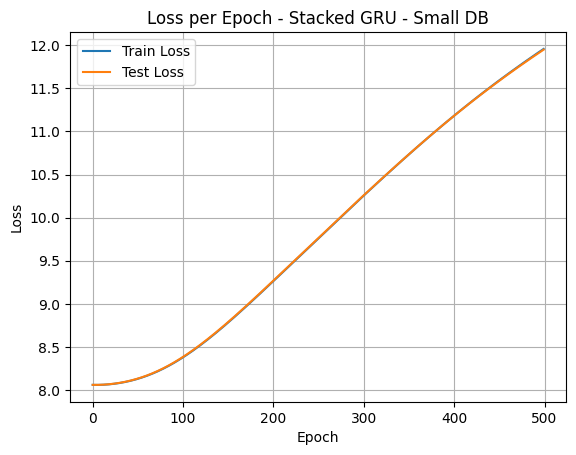

In [41]:
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.title("Loss per Epoch - Stacked GRU - Small DB")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

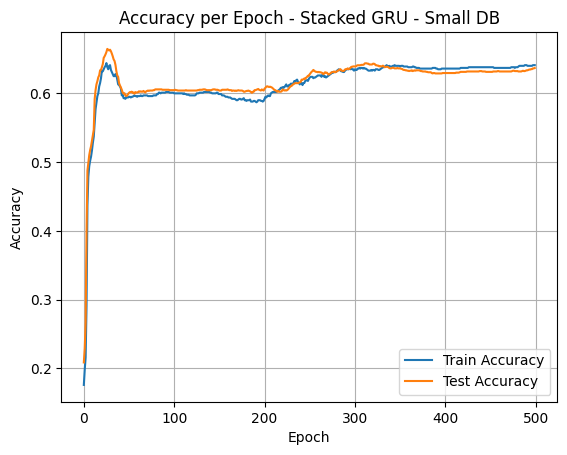

In [42]:
plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(test_accuracies, label="Test Accuracy")
plt.title("Accuracy per Epoch - Stacked GRU - Small DB")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()